# **Key Phrase Impact Analysis on Sales Outcomes**

This notebook presents an analysis to identify key phrases used by account executives in sales transcripts and evaluates their impact on sales outcomes. By leveraging advanced natural language processing and statistical techniques, we aim to uncover phrases that correlate with successful sales (`closed_won`) or unsuccessful sales (`closed_lost`).

## **Table of Contents**
1. [Introduction](#introduction)
2. [Data Loading and Preparation](#data-loading)
3. [Text Preprocessing](#text-preprocessing)
4. [Embedding Generation](#embedding-generation)
5. [Clustering Embeddings](#clustering)
6. [Key Phrase Extraction](#key-phrase-extraction)
7. [Data Aggregation](#data-aggregation)
   - 7.1 [Meeting-Level Aggregation](#meeting-level-aggregation)
   - 7.2 [Phrase-Level Aggregation with Frequency](#phrase-level-aggregation)
8. [Statistical Analysis](#statistical-analysis)
   - 8.1 [Meeting-Level Analysis](#meeting-level-analysis)
   - 8.2 [Phrase-Level Analysis](#phrase-level-analysis)
9. [Model Interpretation](#model-interpretation)
10. [Visualization](#visualization)
11. [Conclusion and Recommendations](#conclusion)

---

<a id='introduction'></a>
## **1. Introduction**

Understanding the language used by account executives during sales meetings can provide valuable insights into factors that contribute to successful sales outcomes. This analysis focuses on extracting key phrases from sales transcripts and assessing their impact on whether a sale was won or lost. By identifying these phrases, we can offer actionable recommendations to improve sales strategies and training programs.

**Key Objectives:**

- **Extract meaningful phrases** from sales transcripts spoken by account executives.
- **Generate embeddings** to capture semantic similarities between phrases.
- **Cluster similar phrases** to identify common themes.
- **Perform statistical analysis** to determine the impact of phrases on sales outcomes.
- **Provide insights** for enhancing sales performance.

<a id='data-loading'></a>
## **2. Data Loading and Preparation**

### **Install Required Packages**
Let's start by installing the necessary packages to allow us to run the notebook.

In [ ]:
# Install necessary packages
import subprocess
import sys

# Install tqdm
subprocess.check_call([sys.executable, "-m", "pip", "install", "tqdm"])

from tqdm.notebook import tqdm

packages = [
    "pandas", "matplotlib", "seaborn", "scipy",
    "scikit-learn", "sentence_transformers", "nltk", "umap-learn",
    "imblearn", "gspread", "spacy", "numpy<2.0", "threadpoolctl", "statsmodels"
]

# Install packages individually with tqdm progress bar
for package in tqdm(packages, desc="Installing packages"):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Download spaCy model
result = subprocess.run("python -m spacy download en_core_web_sm", shell=True, capture_output=True, text=True)

### **Load the Data**
We start by loading the dataset, which consists of transcripts from sales meetings and their associated sales outcomes. The data is preprocessed to focus on sentences spoken by account executives, as these are the primary drivers of the sales process.

**Data Components:**

- **Transcript IDs and Outcomes:** A list containing transcript IDs and their corresponding sales outcomes (`closed_won` or `closed_lost`).
- **Sentences Data (`all_sentences_df`):** Contains sentence-level data, including speaker information and the text spoken.

To optimize processing time, we check if the preprocessed data files exist and load them if available. Otherwise, we perform the data loading and preprocessing steps.

In [2]:
# Import necessary libraries
import pandas as pd
import os
import time
from tqdm.notebook import tqdm
from services.gspread import (
    gspread_try_get_cells_by_range,
    gspread_try_get_service_account_from_file,
    gspread_try_get_spreadsheet_by_id,
    gspread_try_get_worksheet_by_id
)


# Function to load sentences data
def load_sentences_data():
    if os.path.exists('all_sentences_df.csv'):
        # Read the DataFrame from the CSV file
        all_sentences_df = pd.read_csv('all_sentences_df.csv')
        return all_sentences_df
    else:
        # Get data from Google Sheets
        service_account = gspread_try_get_service_account_from_file('secret_sales_meetings_report_service_account.json')
        spreadsheet = gspread_try_get_spreadsheet_by_id(
            service_account,
            '19AYpEl2TeqUAAZ-pqGU3c9j6rtzzFbWgRrEjHA_ozYM'  # Production spreadsheet
        )
        sheet_metrics_per_transcript = gspread_try_get_worksheet_by_id(spreadsheet, 1963712501)

        # Fetch IDs from Google Sheets
        ids = gspread_try_get_cells_by_range(sheet_metrics_per_transcript, 'A3:E')

        # Convert list of dictionaries
        ids = [
            {
                'id': row[0],
                'sales_outcome': row[4],
            }
            for row in ids
        ]

        from algorithms.get_transcript import get_transcript_dfs

        # Convert the list of dictionaries to a DataFrame and remove duplicates
        ids_df = pd.DataFrame(ids)
        ids_df = ids_df.drop_duplicates(subset='id')
        ids = ids_df.to_dict('records')

        # Initialize an empty list to store all sentences
        all_sentences = []

        # Iterate over the IDs with tqdm for progress tracking
        for item in tqdm(ids, desc="Processing IDs"):
            transcript_id = item['id']
            sales_outcome = item['sales_outcome']

            retries = 5
            delay = 2  # Initial delay in seconds
            for attempt in range(1, retries + 1):
                try:
                    # Fetch the dataframes
                    transcript_dfs = get_transcript_dfs(transcript_id)
                    meeting_df = transcript_dfs['meeting_df']
                    sentences_df = transcript_dfs['sentences_df']

                    # Add 'sales_outcome' to sentences_df
                    sentences_df['sales_outcome'] = sales_outcome
                    sentences_df['id'] = transcript_id

                    # Filter for account executives
                    ae_sentences = sentences_df[sentences_df['is_account_executive']]

                    # Append to list
                    all_sentences.append(ae_sentences)

                    # Break out of the retry loop if successful
                    break
                except Exception as e:
                    if attempt == retries:
                        print(f"Failed to process transcript_id {transcript_id} after {retries} attempts.")
                        raise e  # Re-raise the exception after final attempt
                    else:
                        wait_time = delay * (2 ** (attempt - 1))  # Exponential backoff
                        print(f"Attempt {attempt} failed for transcript_id {transcript_id}. Retrying in {wait_time} seconds...")
                        time.sleep(wait_time)

        # Concatenate all sentences into a single DataFrame
        all_sentences_df = pd.concat(all_sentences, ignore_index=True)

        # Display the first few rows
        print(all_sentences_df.head())

        # Export the DataFrame to CSV
        all_sentences_df.to_csv('all_sentences_df.csv', index=False)
        print("Saved 'all_sentences_df.csv' successfully.")
        
        return all_sentences_df


# Load the sentences data
all_sentences_df = load_sentences_data()

<a id='text-preprocessing'></a>
## **3. Text Preprocessing**

We preprocess the text data to extract meaningful phrases that can be used for analysis. The preprocessing involves:

- **Tokenization:** Splitting sentences into words.
- **Lemmatization:** Reducing words to their base forms.
- **Stop Words Removal:** Eliminating common words that do not contribute to the meaning.
- **Part-of-Speech Tagging:** Focusing on nouns and adjectives to capture significant content.
- **Named Entity Recognition:** Identifying entities like organizations, products, etc.

By applying these steps, we aim to distill the sentences into key phrases that encapsulate the main ideas conveyed by the account executives.

**Key Terms Explained:**

- **Tokenization:** The process of breaking text into smaller units (tokens), such as words or phrases.
- **Lemmatization:** Transforming words to their dictionary form (lemma) to reduce variations.
- **Stop Words:** Common words (e.g., 'the', 'and', 'is') that are often removed to focus on significant terms.
- **Part-of-Speech Tagging (POS):** Assigning grammatical categories (e.g., noun, verb) to each word.
- **Named Entity Recognition (NER):** Identifying and classifying key information in text (e.g., names of people, organizations).

In [3]:
# Import necessary libraries for text preprocessing
import spacy
import nltk
from nltk.corpus import stopwords
import ast

# Load the spaCy English model
nlp = spacy.load('en_core_web_sm')

# Initialize stop words
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))
custom_stop_words = stop_words.union({'yeah', 'um', 'so', 'like', 'uh', 'hmm'})

# Define the text preprocessing function
def preprocess_text(text):
    # Check for NaN
    if pd.isnull(text):
        return []
    
    # Process the text with spaCy
    doc = nlp(text.lower())
    
    # Initialize list to hold meaningful phrases
    phrases = []
    
    # Extract noun chunks (noun phrases)
    for chunk in doc.noun_chunks:
        # Collect adjectives and nouns within the chunk
        tokens = [
            token.text
            for token in chunk
            if token.pos_ in ['ADJ', 'NOUN', 'PROPN'] 
            and token.is_alpha 
            and not token.is_stop 
            and token.text not in custom_stop_words
        ]
        if tokens:
            phrase = ' '.join(tokens)
            phrases.append(phrase)
    
    # Extract named entities
    entities = [
        ent.text.lower()
        for ent in doc.ents
        if ent.label_ in ['PERSON', 'ORG', 'GPE', 'PRODUCT', 'EVENT']
    ]
    phrases.extend(entities)
    
    # Remove duplicates while preserving order
    seen = set()
    unique_phrases = []
    for phrase in phrases:
        if phrase not in seen:
            seen.add(phrase)
            unique_phrases.append(phrase)
    
    return unique_phrases

# Apply the preprocessing function if necessary
if os.path.exists('all_sentences_df_with_phrases.csv'):
    # Load the DataFrame from CSV
    all_sentences_df = pd.read_csv('all_sentences_df_with_phrases.csv')
    # Convert 'phrases' column from string representation to actual lists
    all_sentences_df['phrases'] = all_sentences_df['phrases'].apply(ast.literal_eval)
else:
    # Perform text preprocessing
    tqdm.pandas()
    all_sentences_df['phrases'] = all_sentences_df['text'].progress_apply(preprocess_text)
    # Save the DataFrame to CSV
    all_sentences_df.to_csv('all_sentences_df_with_phrases.csv', index=False)

**Explanation:**

- **File Check:** We first check if `all_sentences_df_with_phrases.csv` exists to avoid reprocessing the text data.
- **Loading Data:** If the file exists, we load the DataFrame and convert the 'phrases' column back to lists.
- **Text Preprocessing:** If the file doesn't exist, we apply the `preprocess_text` function to extract meaningful phrases and save the DataFrame for future use.

### **Explode Phrases into Separate Rows**

To facilitate analysis, we expand the DataFrame so that each phrase has its own row. This allows us to generate embeddings and perform clustering at the phrase level.

In [4]:
# Expand the DataFrame if necessary
if os.path.exists('expanded_df.parquet'):
    expanded_df = pd.read_parquet('expanded_df.parquet')
else:
    # Ensure 'phrases' column contains lists
    if all_sentences_df['phrases'].apply(lambda x: isinstance(x, list)).all():
        pass
    else:
        all_sentences_df['phrases'] = all_sentences_df['phrases'].apply(ast.literal_eval)
    
    # Explode the phrases into separate rows
    expanded_df = all_sentences_df.explode('phrases').reset_index(drop=True)
    
    # Rename 'phrases' to 'clean_text' for consistency
    expanded_df.rename(columns={'phrases': 'clean_text'}, inplace=True)
    
    # Drop rows where 'clean_text' is NaN or empty
    expanded_df = expanded_df[expanded_df['clean_text'].notna() & (expanded_df['clean_text'] != '')]
    
    # Save the DataFrame to a Parquet file
    expanded_df.to_parquet('expanded_df.parquet', index=False)

<a id='embedding-generation'></a>
## **4. Embedding Generation**

We generate embeddings for each phrase using a pre-trained language model. Embeddings are numerical representations of text that capture semantic meaning, allowing us to measure similarity between phrases.

**Key Terms Explained:**

- **Embedding:** A numerical representation of text in a high-dimensional space, capturing semantic relationships.
- **Pre-trained Language Model:** A model trained on a large corpus of text data, which can generate embeddings for new text.

In [5]:
# Import necessary library for embeddings
from sentence_transformers import SentenceTransformer
import numpy as np

# Generate embeddings if necessary
if os.path.exists('expanded_df_with_embeddings.parquet'):
    expanded_df = pd.read_parquet('expanded_df_with_embeddings.parquet')
else:
    # Load the model
    model = SentenceTransformer('all-MiniLM-L6-v2')
    
    # Generate embeddings
    embeddings = model.encode(expanded_df['clean_text'].tolist(), show_progress_bar=True)
    
    # Add embeddings to DataFrame
    expanded_df['embedding'] = embeddings.tolist()
    
    # Save the DataFrame to a Parquet file
    expanded_df.to_parquet('expanded_df_with_embeddings.parquet', index=False)

C:\Users\Dan Labrador\AppData\Roaming\Python\Python312\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


**Explanation:**

- **File Check:** We check if `expanded_df_with_embeddings.parquet` exists to avoid regenerating embeddings.
- **Generating Embeddings:** If not, we use a pre-trained model to generate embeddings for each phrase and save the DataFrame.

<a id='clustering'></a>
## **5. Clustering Embeddings**

We cluster the phrase embeddings to identify groups of semantically similar phrases. This helps us to uncover common themes and patterns in the language used by account executives.

**Key Terms Explained:**

- **Clustering:** Grouping data points (embeddings) that are similar to each other.
- **K-Means Clustering:** A popular clustering algorithm that partitions data into K clusters.
- **Dimensionality Reduction:** Reducing the number of features (dimensions) in data while preserving important information.
- **Principal Component Analysis (PCA):** A technique for dimensionality reduction by identifying principal components.

In [6]:
# Import necessary libraries for clustering
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA

# Perform clustering if necessary
if os.path.exists('expanded_df_with_clusters.parquet'):
    expanded_df = pd.read_parquet('expanded_df_with_clusters.parquet')
else:
    # Convert embeddings to array
    embedding_array = np.array(expanded_df['embedding'].tolist(), dtype=np.float32)
    
    # Dimensionality Reduction using PCA
    pca = PCA(n_components=0.95, random_state=42)
    reduced_embeddings = pca.fit_transform(embedding_array)
    
    # Clustering using MiniBatchKMeans
    num_clusters = 100  # Adjust as needed
    kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=42, batch_size=10000)
    kmeans.fit(reduced_embeddings)
    
    # Assign cluster labels
    expanded_df['cluster'] = kmeans.labels_
    
    # Save the DataFrame with cluster assignments
    expanded_df.to_parquet('expanded_df_with_clusters.parquet', index=False)

**Explanation:**

- **File Check:** We check if `expanded_df_with_clusters.parquet` exists to avoid re-clustering.
- **PCA:** We reduce the dimensionality of embeddings to speed up clustering.
- **K-Means Clustering:** We cluster the reduced embeddings into a predefined number of clusters.
- **Saving Results:** The clustered data is saved for future use.

<a id='key-phrase-extraction'></a>
## **6. Key Phrase Extraction**

For each cluster, we extract a representative key phrase. This is typically the most frequent phrase within the cluster, which serves as a summary of the cluster's theme.

In [7]:
# Extract key phrases if necessary
if os.path.exists('expanded_df_with_key_phrases.parquet'):
    expanded_df = pd.read_parquet('expanded_df_with_key_phrases.parquet')
else:
    # Ensure 'num_clusters' is defined
    num_clusters = expanded_df['cluster'].nunique()

    # Initialize a dictionary to store cluster labels
    cluster_labels = {}

    for cluster_num in range(num_clusters):
        # Filter phrases in the cluster
        cluster_phrases = expanded_df[expanded_df['cluster'] == cluster_num]

        if cluster_phrases.empty:
            # Assign 'N/A' if the cluster has no phrases
            key_phrase = 'N/A'
        else:
            # Get all phrases in the cluster
            phrases = cluster_phrases['clean_text'].tolist()

            # Count the frequency of each phrase
            phrase_counts = pd.Series(phrases).value_counts()

            # Assign the most frequent phrase as the key phrase
            key_phrase = phrase_counts.index[0]

        # Store the assigned key phrase
        cluster_labels[cluster_num] = key_phrase

    # Map cluster labels
    expanded_df['key_phrase'] = expanded_df['cluster'].map(cluster_labels)

    # Save the DataFrame with key phrases
    expanded_df.to_parquet('expanded_df_with_key_phrases.parquet', index=False)

**Explanation:**

- **File Check:** We check if `expanded_df_with_key_phrases.parquet` exists.
- **Key Phrase Assignment:** For each cluster, we identify the most frequent phrase as the key phrase.
- **Mapping Key Phrases:** The key phrases are mapped back to the DataFrame for further analysis.
- **Saving Results:** The DataFrame with key phrases is saved for future use.

<a id='data-aggregation'></a>
## **7. Data Aggregation**

We perform two types of data aggregation to prepare for statistical analysis:

### **7.1 Meeting-Level Aggregation**

At the meeting level, we aggregate key phrases to indicate whether each key phrase was used in a meeting. This binary representation helps us understand the presence or absence of key themes in successful and unsuccessful sales meetings.

In [11]:
# Group by meeting ID and collect unique key phrases
meeting_key_phrases = expanded_df.groupby('id')['key_phrase'].apply(lambda x: list(set(x))).reset_index()

# Get the sales outcome for each meeting
meeting_outcomes = expanded_df[['id', 'sales_outcome']].drop_duplicates()

# Merge key phrases with sales outcomes
meeting_level_df = pd.merge(meeting_key_phrases, meeting_outcomes, on='id')

# Create binary features for each key phrase
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
key_phrase_matrix = mlb.fit_transform(meeting_level_df['key_phrase'])
key_phrase_df = pd.DataFrame(key_phrase_matrix, columns=mlb.classes_)
meeting_level_df = pd.concat([meeting_level_df, key_phrase_df], axis=1)

# Map sales outcome to binary
meeting_level_df['sales_outcome_binary'] = meeting_level_df['sales_outcome'].map({'closed_won': 1, 'closed_lost': 0})

# Save the DataFrame
meeting_level_df.to_parquet('meeting_level_df.parquet', index=False)

### **7.2 Phrase-Level Aggregation with Frequency**

At the phrase level, we consider the frequency of each key phrase within each meeting. This allows us to analyze how often specific phrases are used and their correlation with sales outcomes.

In [9]:
# Perform phrase-level aggregation if necessary
if os.path.exists('phrase_level_df.parquet'):
    phrase_level_df = pd.read_parquet('phrase_level_df.parquet')
else:
    # Count the frequency of each key phrase per meeting
    phrase_frequency = expanded_df.groupby(['id', 'key_phrase']).size().unstack(fill_value=0).reset_index()

    # Get the sales outcome for each meeting
    meeting_outcomes = expanded_df[['id', 'sales_outcome']].drop_duplicates()

    # Merge phrase frequencies with sales outcomes
    phrase_level_df = pd.merge(phrase_frequency, meeting_outcomes, on='id')

    # Map sales outcome to binary
    phrase_level_df['sales_outcome_binary'] = phrase_level_df['sales_outcome'].map({'closed_won': 1, 'closed_lost': 0})

    # Save the DataFrame
    phrase_level_df.to_parquet('phrase_level_df.parquet', index=False)

<a id='statistical-analysis'></a>
## **8. Statistical Analysis**

We perform statistical analyses to determine the relationship between key phrases and sales outcomes.

### **8.1 Meeting-Level Analysis**

We use logistic regression to model the probability of a successful sale based on the presence of key phrases in meetings.

**Key Terms Explained:**

- **Logistic Regression:** A statistical model used for binary classification that models the probability of an outcome.
- **Odds Ratio:** A measure of the association between a feature and an outcome; values greater than 1 indicate a positive association.

In [21]:
# Prepare data for logistic regression using statsmodels
import statsmodels.api as sm

# Features and target
X = meeting_level_df[mlb.classes_]
y = meeting_level_df['sales_outcome_binary']

# Add a constant term for the intercept
X = sm.add_constant(X)

# Fit logistic regression model using statsmodels
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Extract coefficients and p-values
coefficients_meeting = pd.DataFrame({
    'phrase': X.columns[1:],  # Exclude 'const'
    'coefficient': result.params[1:],  # Exclude 'const'
    'p_value': result.pvalues[1:]      # Exclude 'const'
})

# Calculate odds ratios
coefficients_meeting['odds_ratio'] = np.exp(coefficients_meeting['coefficient'])

# Determine significance based on p-value
coefficients_meeting['significant'] = coefficients_meeting['p_value'] < 0.05

# Calculate absolute coefficient values for sorting
coefficients_meeting['abs_coefficient'] = coefficients_meeting['coefficient'].abs()

# Sort the DataFrame
coefficients_meeting.sort_values(by=['significant', 'abs_coefficient'], ascending=[False, False], inplace=True)

# Export the results
coefficients_meeting.to_csv('logistic_regression_results.csv', index=False)


Optimization terminated successfully.
         Current function value: 0.512452
         Iterations 6


### **8.2 Phrase-Level Analysis**

For count data, we use Poisson regression to model the relationship between the frequency of key phrases and sales outcomes.

**Key Terms Explained:**

- **Poisson Regression:** A statistical model used for count data to model the expected count of events.
- **Count Data:** Data representing the number of times an event occurs.

In [ ]:
# Prepare data for Poisson regression
import statsmodels.api as sm

X_counts = phrase_level_df.drop(columns=['id', 'sales_outcome', 'sales_outcome_binary'])
y_counts = phrase_level_df['sales_outcome_binary']

# Add a constant term for the intercept
X_counts = sm.add_constant(X_counts)

# Build the Poisson regression model
poisson_model = sm.GLM(y_counts, X_counts, family=sm.families.Poisson()).fit()

# Extract coefficients and p-values
poisson_results = poisson_model.summary2().tables[1].reset_index()
poisson_results.rename(columns={'index': 'phrase', 'Coef.': 'coefficient', 'P>|z|': 'p_value'}, inplace=True)

# Exclude 'const' term
coefficients_phrase = poisson_results[poisson_results['phrase'] != 'const']

# Determine significance based on p-value
coefficients_phrase['significant'] = coefficients_phrase['p_value'] < 0.05

# Calculate absolute coefficient values for sorting
coefficients_phrase['abs_coefficient'] = coefficients_phrase['coefficient'].abs()

# Sort the DataFrame
coefficients_phrase.sort_values(by=['significant', 'abs_coefficient'], ascending=[False, False], inplace=True)

# Export the results
coefficients_phrase.to_csv('poisson_regression_results.csv', index=False)


<a id='model-interpretation'></a>
## **9. Model Interpretation**

We analyze the coefficients and p-values from both the logistic regression and Poisson regression models to understand which key phrases have a significant impact on sales outcomes.

### **9.1 Meeting-Level Model Interpretation**
- **Objective:** To identify which phrases, when present in a meeting, are associated with the likelihood of a successful sale.
- **Approach:** We use logistic regression to model the probability of a sale being closed (won or lost) based on the presence or absence of key phrases in each meeting.
- **Interpretation:** A positive coefficient indicates that the presence of a phrase increases the odds of a successful sale, while a negative coefficient suggests the opposite.

**Key Findings:**

- **Significant Phrases:** Phrases with p-values less than 0.05 are considered statistically significant.
- **Positive Coefficients:** Indicate phrases that, when present in a meeting, are associated with higher odds of a successful sale.
- **Negative Coefficients:** Indicate phrases that, when present, are associated with lower odds of a successful sale.

#### **Table 1: Positive Phrases (Meeting-Level Logistic Regression)**

| Phrase   | Coefficient | p-value   | Odds Ratio | Interpretation                                |
|----------|-------------|-----------|------------|-----------------------------------------------|
| people   | 0.485       | 0.02695   | 1.625      | Increases odds of success by ~62%             |
| design   | 0.436       | 0.00475   | 1.546      | Increases odds of success by ~55%             |
| team     | 0.416       | 0.00829   | 1.516      | Increases odds of success by ~52%             |
| days     | 0.408       | 0.00978   | 1.504      | Increases odds of success by ~50%             |
| half     | 0.366       | 0.00928   | 1.443      | Increases odds of success by ~44%             |
| audit    | 0.347       | 0.00708   | 1.415      | Increases odds of success by ~41%             |
| category | 0.290       | 0.01620   | 1.336      | Increases odds of success by ~34%             |
| email    | 0.282       | 0.02691   | 1.326      | Increases odds of success by ~33%             |

#### **Table 2: Negative Phrases (Meeting-Level Logistic Regression)**

| Phrase   | Coefficient | p-value   | Odds Ratio | Interpretation                                 |
|----------|-------------|-----------|------------|-----------------------------------------------|
| seo      | -0.668      | 0.00015   | 0.513      | Decreases odds of success by ~49%             |
| video    | -0.508      | 0.00023   | 0.602      | Decreases odds of success by ~40%             |
| service  | -0.378      | 0.03019   | 0.685      | Decreases odds of success by ~31%             |
| idea     | -0.365      | 0.00199   | 0.694      | Decreases odds of success by ~31%             |
| example  | -0.331      | 0.01237   | 0.718      | Decreases odds of success by ~28%             |
| look     | -0.301      | 0.00799   | 0.740      | Decreases odds of success by ~26%             |

**Interpretation:**

- **Positive Impact Phrases:**
  - **"people," "design," "team," "days," "half," "audit," "category," "email":** These phrases are associated with increased odds of a successful sale when mentioned during meetings. They likely emphasize collaboration, planning, and client engagement, resonating well with clients.

- **Negative Impact Phrases:**
  - **"seo," "video," "service," "idea," "example," "look":** These phrases are associated with decreased odds of a successful sale. They may indicate a focus on technical details or abstract concepts that do not align with client priorities.

### **9.2 Phrase-Level Model Interpretation**
- **Objective:** To determine how the frequency of phrase usage within meetings affects sales outcomes.
- **Approach:** We employ Poisson regression to model the count of successful sales events relative to the frequency of key phrases used in meetings.
- **Interpretation:** A positive coefficient means that more frequent use of a phrase is associated with higher expected counts of successful sales, whereas a negative coefficient indicates a potential negative impact.

**Key Findings:**

- **Significant Phrases:** Phrases with p-values less than 0.05 in the Poisson regression model are considered statistically significant.
- **Positive Coefficients:** Indicate that higher frequencies of these phrases are associated with higher expected counts of successful sales.
- **Negative Coefficients:** Suggest that frequent use of these phrases is associated with lower expected counts of successful sales.

#### **Table 3: Positive Phrases (Phrase-Level Poisson Regression)**

| Phrase   | Coefficient | p-value   | Interpretation                                                    |
|----------|-------------|-----------|-------------------------------------------------------------------|
| proposal | 0.049       | 0.00190   | Frequent mentions associated with increased sales success         |
| days     | 0.037       | 0.02059   | Frequent mentions correlate with higher sales success             |
| money    | 0.036       | 0.03942   | Frequent discussions positively associated with sales success     |
| week     | 0.035       | 0.00057   | Frequent mentions indicate higher likelihood of sales success     |
| team     | 0.034       | 0.00920   | Emphasizing "team" correlates with increased sales success        |

#### **Table 4: Negative Phrases (Phrase-Level Poisson Regression)**

| Phrase | Coefficient | p-value   | Interpretation                                                   |
|--------|-------------|-----------|------------------------------------------------------------------|
| look   | -0.064      | 0.01264   | Frequent use associated with decreased sales success             |
| idea   | -0.049      | 0.04802   | Repeated mentions may negatively impact sales success            |

**Interpretation:**

- **Positive Impact Phrases:**
  - **"proposal," "days," "money," "week," "team":** Frequent use of these phrases suggests a focus on concrete actions, timelines, financial considerations, and collaboration, which positively influence sales outcomes.

- **Negative Impact Phrases:**
  - **"look," "idea":** Overuse of these phrases may detract from the clarity and effectiveness of the sales pitch, possibly indicating vagueness or lack of specific value propositions.

### **Why Use Meeting-Level and Phrase-Level Analyses**
- **Different Perspectives:** Meeting-level analysis helps us understand the impact of simply mentioning a phrase, regardless of how often it is used, while phrase-level analysis delves into whether using a phrase more frequently within a meeting affects the outcome.
- **Comprehensive Insights:** By examining both presence and frequency, we gain a fuller picture of how language influences sales success, enabling more targeted recommendations.



<a id='visualization'></a>
## **10. Visualization**

We present visualizations to illustrate the key findings from our analysis, highlighting the phrases that most strongly influence sales outcomes.

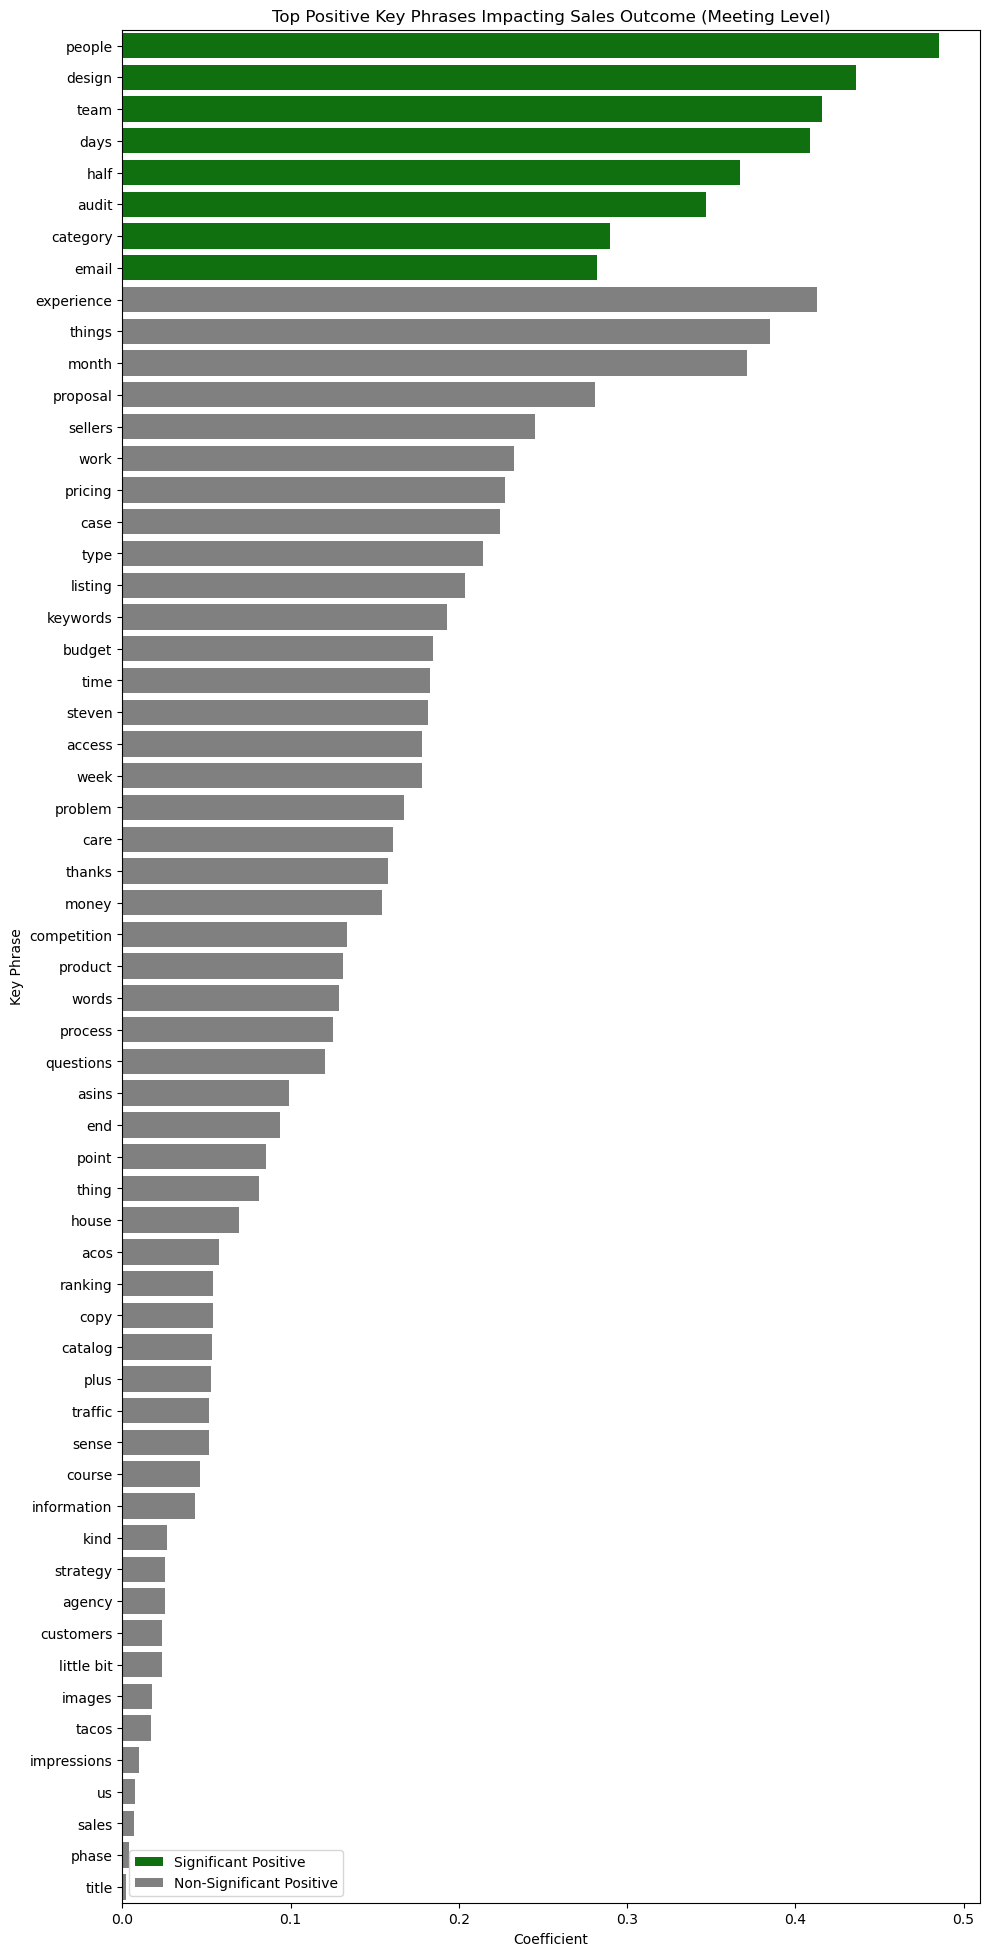

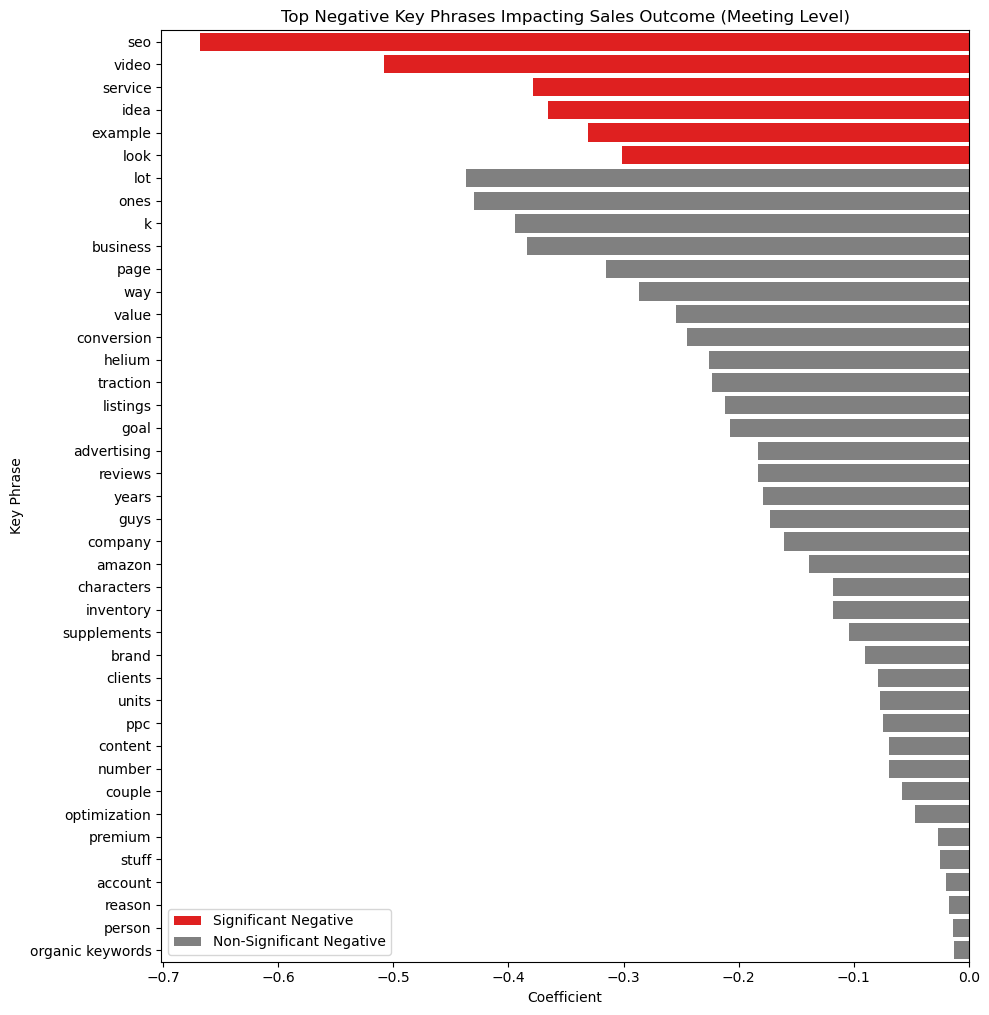

In [25]:
# Visualization for Meeting-Level Analysis

import matplotlib.pyplot as plt
import seaborn as sns

# Read the coefficients from CSV
coefficients_meeting = pd.read_csv('logistic_regression_results.csv')

# Separate significant and non-significant phrases
significant_phrases = coefficients_meeting[coefficients_meeting['significant']]
non_significant_phrases = coefficients_meeting[~coefficients_meeting['significant']]

# Separate positive and negative coefficients
significant_positive = significant_phrases[significant_phrases['coefficient'] > 0]
significant_negative = significant_phrases[significant_phrases['coefficient'] < 0]

non_significant_positive = non_significant_phrases[non_significant_phrases['coefficient'] > 0]
non_significant_negative = non_significant_phrases[non_significant_phrases['coefficient'] < 0]

# Sort phrases by absolute value of coefficient
significant_positive = significant_positive.sort_values('abs_coefficient', ascending=False)
significant_negative = significant_negative.sort_values('abs_coefficient', ascending=False)
non_significant_positive = non_significant_positive.sort_values('abs_coefficient', ascending=False)
non_significant_negative = non_significant_negative.sort_values('abs_coefficient', ascending=False)

# Plot Top Positive Phrases
plt.figure(figsize=(10, (len(significant_positive) + len(non_significant_positive))/3))

# Plot significant positive phrases
sns.barplot(
    x='coefficient',
    y='phrase',
    data=significant_positive,
    color='green',
    label='Significant Positive'
)

# Overlay non-significant positive phrases
sns.barplot(
    x='coefficient',
    y='phrase',
    data=non_significant_positive,
    color='gray',
    label='Non-Significant Positive'
)

plt.title('Top Positive Key Phrases Impacting Sales Outcome (Meeting Level)')
plt.xlabel('Coefficient')
plt.ylabel('Key Phrase')
plt.legend()
plt.tight_layout()
plt.show()

# Plot Top Negative Phrases
plt.figure(figsize=(10, (len(significant_negative) + len(non_significant_negative))/4))

# Plot significant negative phrases
sns.barplot(
    x='coefficient',
    y='phrase',
    data=significant_negative,
    color='red',
    label='Significant Negative'
)

# Overlay non-significant negative phrases
sns.barplot(
    x='coefficient',
    y='phrase',
    data=non_significant_negative,
    color='gray',
    label='Non-Significant Negative'
)

plt.title('Top Negative Key Phrases Impacting Sales Outcome (Meeting Level)')
plt.xlabel('Coefficient')
plt.ylabel('Key Phrase')
plt.legend()
plt.tight_layout()
plt.show()


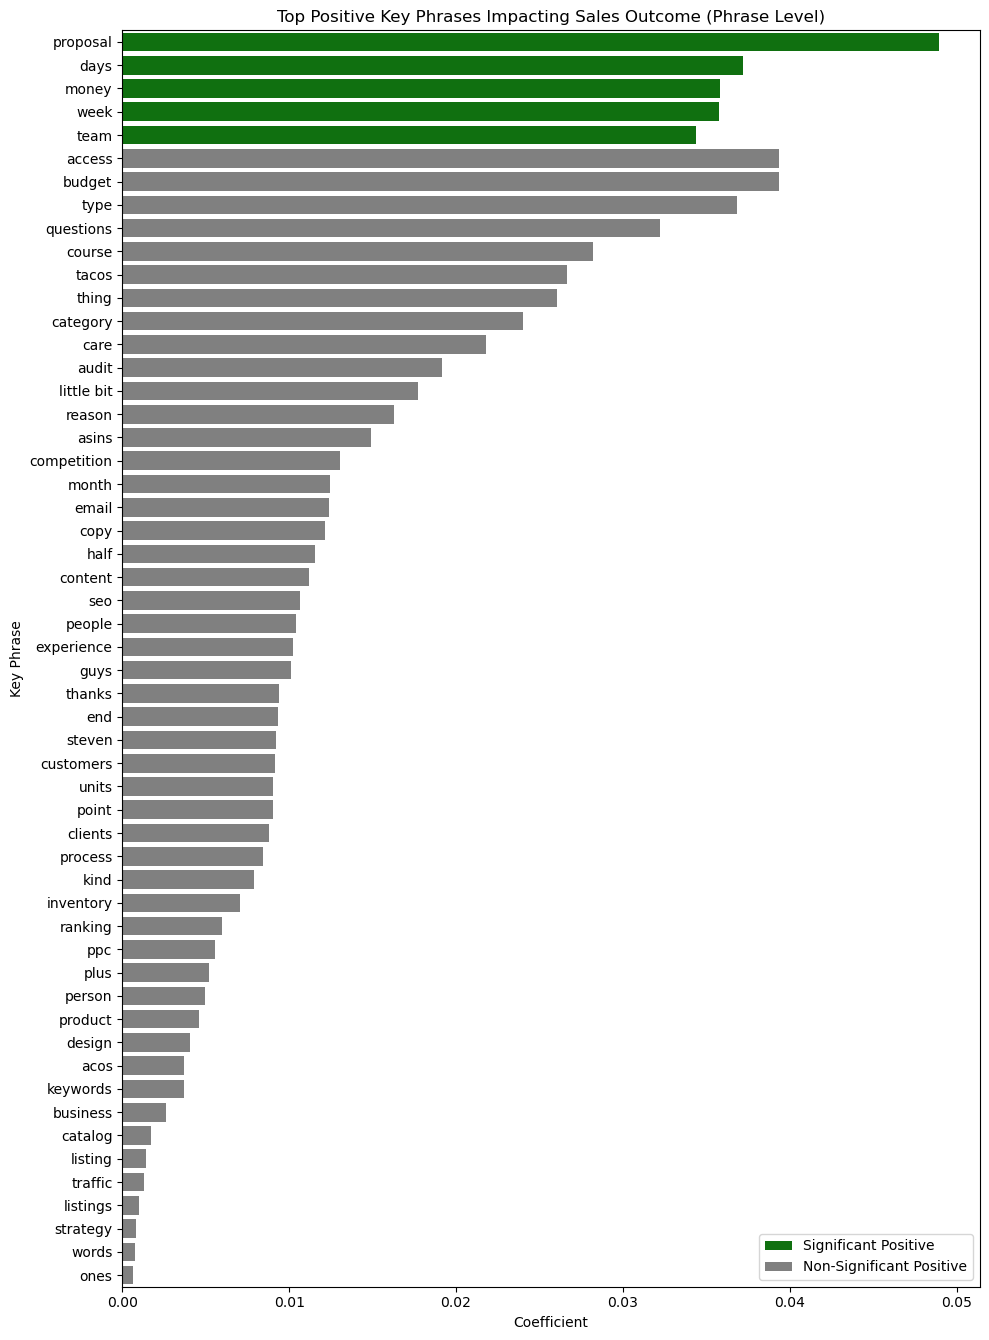

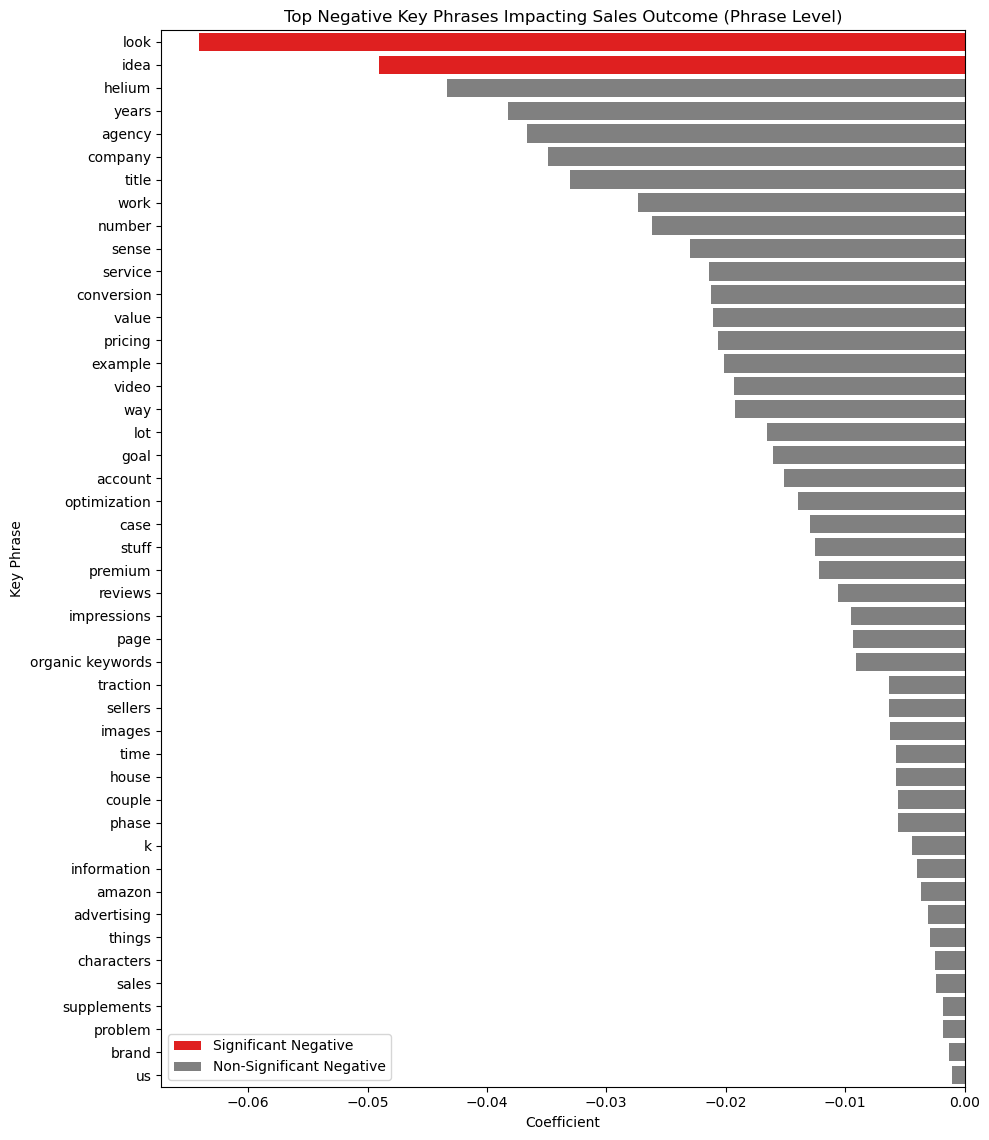

In [26]:
# Visualization for Phrase-Level Analysis

import matplotlib.pyplot as plt
import seaborn as sns

# Read the coefficients from CSV
coefficients_phrase = pd.read_csv('poisson_regression_results.csv')

# Separate significant and non-significant phrases
significant_phrases = coefficients_phrase[coefficients_phrase['significant']]
non_significant_phrases = coefficients_phrase[~coefficients_phrase['significant']]

# Separate positive and negative coefficients
significant_positive = significant_phrases[significant_phrases['coefficient'] > 0]
significant_negative = significant_phrases[significant_phrases['coefficient'] < 0]

non_significant_positive = non_significant_phrases[non_significant_phrases['coefficient'] > 0]
non_significant_negative = non_significant_phrases[non_significant_phrases['coefficient'] < 0]

# Sort phrases by absolute value of coefficient
significant_positive = significant_positive.sort_values('abs_coefficient', ascending=False)
significant_negative = significant_negative.sort_values('abs_coefficient', ascending=False)
non_significant_positive = non_significant_positive.sort_values('abs_coefficient', ascending=False)
non_significant_negative = non_significant_negative.sort_values('abs_coefficient', ascending=False)

# Plot Top Positive Phrases
plt.figure(figsize=(10, (len(significant_positive) + len(non_significant_positive))/4))

# Plot significant positive phrases
sns.barplot(
    x='coefficient',
    y='phrase',
    data=significant_positive,
    color='green',
    label='Significant Positive'
)

# Overlay non-significant positive phrases
sns.barplot(
    x='coefficient',
    y='phrase',
    data=non_significant_positive,
    color='gray',
    label='Non-Significant Positive'
)

plt.title('Top Positive Key Phrases Impacting Sales Outcome (Phrase Level)')
plt.xlabel('Coefficient')
plt.ylabel('Key Phrase')
plt.legend()
plt.tight_layout()
plt.show()

# Plot Top Negative Phrases
plt.figure(figsize=(10, (len(significant_negative) + len(non_significant_negative))/4))

# Plot significant negative phrases
sns.barplot(
    x='coefficient',
    y='phrase',
    data=significant_negative,
    color='red',
    label='Significant Negative'
)

# Overlay non-significant negative phrases
sns.barplot(
    x='coefficient',
    y='phrase',
    data=non_significant_negative,
    color='gray',
    label='Non-Significant Negative'
)

plt.title('Top Negative Key Phrases Impacting Sales Outcome (Phrase Level)')
plt.xlabel('Coefficient')
plt.ylabel('Key Phrase')
plt.legend()
plt.tight_layout()
plt.show()


<a id='conclusion'></a>
## **11. Conclusion and Recommendations**

Based on our analysis, we have identified key phrases that significantly impact sales outcomes. These insights can be leveraged to:

- **Enhance Training Programs:** Focus on encouraging the use of positively associated phrases and discouraging negatively associated ones.
- **Refine Sales Strategies:** Adapt communication strategies to include impactful themes identified in the analysis.
- **Monitor Performance:** Continuously track the usage of key phrases to assess their ongoing effectiveness.

### **Next Steps**

- **Share Findings:**
  - Present the analysis to the sales team and discuss practical implementation strategies.
  - **Action:** Organize a meeting or webinar to disseminate the insights and gather feedback.

- **Further Research:**
  - Investigate the effectiveness of phrases across different client segments or industries.
  - **Action:** Conduct segmented analyses to tailor communication strategies more precisely.

- **Continuous Improvement:**
  - Update the analysis periodically with new data to refine understanding and adjust recommendations.
  - **Action:** Schedule regular reviews (e.g., quarterly) to incorporate ongoing learnings.

### **Disclaimer**

- **Statistical Nature of Findings:**
  - The insights provided are based on statistical analyses of historical data and identify correlations between phrase usage and sales outcomes.
  - **Caution:** Correlation does not imply causation. While significant phrases have been identified, it's important to consider the broader context of sales interactions.

- **Decision-Making:**
  - The organization should use its discretion in applying these findings to their sales strategies.
  - **Note:** Not all phrases may be universally applicable or significant in every context.

- **Data Source:**
  - The analysis is based on the utterances of Account Executives (AEs) during sales meetings, not on what clients mention.
  - **Implication:** The findings reflect the impact of AE communication on sales outcomes and do not account for client responses or language.

---

**By leveraging these insights, the organization can enhance its sales strategies, improve training programs, and ultimately increase the success rate of sales meetings.**
